# Function Fitting with a Quantum Neural Network

Using the example from Penny Lane of a variational circuit that learns a
fit for a one-dimensional function, we generate several examples of functions with noise
and train the quantum neural network to fit them. 

The variational circuit used is the continuous-variable quantum neural
network model described in:

`Killoran et al. (2018) <https://arxiv.org/abs/1806.06871>`


In [1]:
# Import PennyLane, the wrapped version of NumPy provided by PennyLane,and an optimizer.
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

In [2]:
# Other imports:
# matplotlib.pyplot to plot and visualize the data
# numpy to generate the mathematical function
# pylab to help with interactive plots
# pickle to dump the data into a file for future use
import matplotlib.pyplot as plt
import numpy as np
import pylab
import pickle

## Creating a Noisy Function for Sampling

In [3]:
Xlim = 5
noise = np.random.normal(0,0.1,100) # generate noise to add to the function values (Y-values)
# define functions
X = np.arange(-Xlim, Xlim, 0.1)
Y = np.sin(X)+noise

This will generate two lists 'X' and 'Y' with our X-axis and Y-axis data. We'll now dump the Y-axis data into our file for future use.

In [4]:
# write the data out to a file
sinedata = open('sinedata.md', 'wb')
pickle.dump(Y, sinedata)
sinedata.close()

The above snippet writes the data of y into a file named sinedata.md. Pickle is specific to Python and it can be used to load the data into another Python script later. Now we plot some of the data:

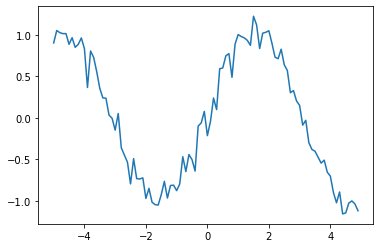

In [5]:
plt.plot(X[0:200], Y[0:200])

So we have some noisy sine data to train our quantum neural network on. The device we use is the Strawberry Fields simulator, this time with only one quantum mode (or ``wire``). You will need to have the Strawberry Fields plugin for PennyLane installed.

In [6]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

### Quantum node
For a single quantum mode, each layer of the variational circuit is defined as:

In [7]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into
the displacement of the mode, and then executes the layers. The output
is the expectation of the x-quadrature.

In [8]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

### Objective
As an objective we take the square loss between target labels and model
predictions.

In [9]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational
circuit. Function fitting is a regression problem, and we interpret the
expectations from the quantum node as predictions (i.e., without
applying postprocessing such as thresholding).


In [10]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    return square_loss(labels, preds)

### Optimization
We load noisy data samples of a sine function.

Before training a model, let’s examine the data.

*Note: For the next cell to work you need the matplotlib library.*


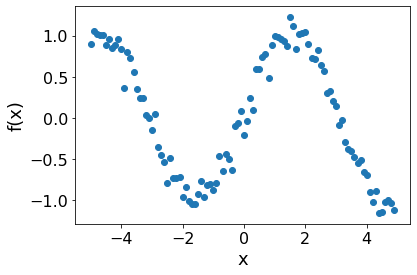

In [11]:
plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

The network’s weights (called ``var`` here) are initialized with values
sampled from a normal distribution. We use 4 layers; performance has
been found to plateau at around 6 layers.

In [12]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 5)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]]


In [13]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(100):
    var = opt.step(lambda v: cost(v, X, Y), var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X, Y)))

Iter:     1 | Cost: 0.4366430 
Iter:     2 | Cost: 0.4130995 
Iter:     3 | Cost: 0.4401763 
Iter:     4 | Cost: 0.4843044 
Iter:     5 | Cost: 0.5272264 
Iter:     6 | Cost: 0.5590949 
Iter:     7 | Cost: 0.5756194 
Iter:     8 | Cost: 0.5762956 
Iter:     9 | Cost: 0.5631025 
Iter:    10 | Cost: 0.5394853 
Iter:    11 | Cost: 0.5095363 
Iter:    12 | Cost: 0.4773198 
Iter:    13 | Cost: 0.4463337 
Iter:    14 | Cost: 0.4191397 
Iter:    15 | Cost: 0.3972019 
Iter:    16 | Cost: 0.3809405 
Iter:    17 | Cost: 0.3699549 
Iter:    18 | Cost: 0.3633300 
Iter:    19 | Cost: 0.3599337 
Iter:    20 | Cost: 0.3586456 
Iter:    21 | Cost: 0.3584964 
Iter:    22 | Cost: 0.3587285 
Iter:    23 | Cost: 0.3588033 
Iter:    24 | Cost: 0.3583769 
Iter:    25 | Cost: 0.3572647 
Iter:    26 | Cost: 0.3554029 
Iter:    27 | Cost: 0.3528146 
Iter:    28 | Cost: 0.3495813 
Iter:    29 | Cost: 0.3458197 
Iter:    30 | Cost: 0.3416648 
Iter:    31 | Cost: 0.3372562 
Iter:    32 | Cost: 0.3327294 
Iter:   

Finally, we collect the predictions of the trained model for 75 values
in the range $[0,30]$:

In [14]:
x_pred = np.linspace(-3, 3, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

and plot the shape of the function that the model has “learned” from
the noisy data (green dots).

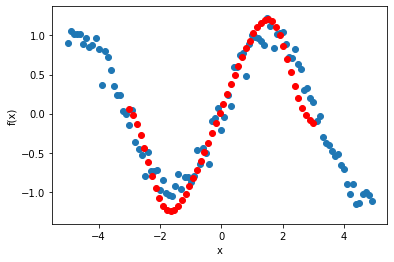

In [15]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="red")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the
model produces without being trained at all. The shape of these
functions varies significantly with the variance hyperparameter for the
weight initialization.

Setting this hyperparameter to a small value produces almost linear
functions, since all quantum gates in the variational circuit
approximately perform the identity transformation in that case. Larger
values produce smoothly oscillating functions with a period that depends
on the number of layers used (generically, the more layers, the smaller
the period).

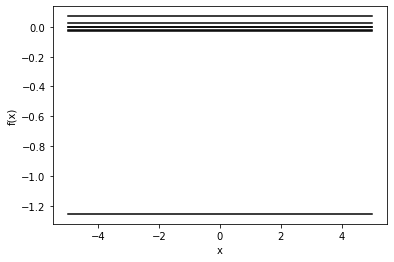

In [16]:
variance = 1.0

plt.figure()
x_pred = np.linspace(-5, 5, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color="black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

## References
PennyLane "Function Fitting with a Quantum Neural Network" ```https://pennylane.ai/qml/app/quantum_neural_net.html```

"Generating and visualizing data from a sine wave in Python" ```https://goelhardik.github.io/2016/05/25/sampling-sine-wave/```

`Killoran et al. (2018) <https://arxiv.org/abs/1806.06871>`

"adding noise to a signal in python" ```https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python```